## Autoreload

In [5]:
%load_ext autoreload
%autoreload 2

## Libraries

In [6]:
import numpy as np
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pywt
from scipy import signal
from scipy.fft import fft, ifft, fftfreq
from scipy.signal import detrend, butter, filtfilt
from scipy.linalg import hankel, svd, eig, toeplitz
import ipywidgets as widgets
from IPython.display import display
from signalepy import plot, settings, utils, analysis
from collections import OrderedDict
from typing import Tuple,Dict, Union, List
from numpy.typing import NDArray
from numba import jit, prange
from dataclasses import dataclass, field
from tqdm import tqdm
import gc





## Parameters

### Accceleration data

**File name and location**

In [7]:
file_name = 'cable_acceleration.txt'
file_location = utils.get_tests_files_location(file_name)


**Import acceleration data**

In [8]:
labels =['X', 'Y', 'Z']
label = 'Z'

In [9]:
df = utils.import_sts_acceleration_txt(file_location, labels) # Import data for wavelets and fft analysis
df_ssicov = utils.import_sts_acceleration_txt(file_location, labels) # Import data for SSICov analysis

In [10]:
df = pd.DataFrame()
df['Time'] = df_ssicov['Time']
df[f'{label} Acceleration'] = df_ssicov[f'{label} Acceleration']

In [11]:
def filter_time_window(
    df: pd.DataFrame, label: str = None, start_time: float = None, window_size: float = None
) -> pd.DataFrame:
    """
    Filters a DataFrame to include only data within a specified time window.

    Args:
        df: DataFrame containing time-series data with a 'Time' column.
        label: Label or identifier (Unused in the current implementation).
        start_time: Start time of the window.
        window_size: Size of the time window.

    Returns:
        A new DataFrame containing only the data within the specified time window,
        or the original DataFrame if start_time or window_size is None.

    Assumptions:
        - The DataFrame has a column named 'Time' with numerical time values.
        - start_time and window_size are numerical values.
    """
    if start_time is None or window_size is None:
        return df

    end_time = start_time + window_size

    # Filter the DataFrame
    filtered_df = df[(df["Time"] >= start_time) & (df["Time"] <= end_time)]

    return filtered_df


In [12]:
def estimate_n(df):
    # Check if the DataFrame is empty
    if df.empty:
        raise ValueError("The DataFrame is empty.")
    
    # Check if 'Time' column exists
    if 'Time' not in df.columns:
        raise KeyError("The 'Time' column does not exist in the DataFrame.")
    
    # Access the first and second elements using .iloc
    delta_t = df['Time'].iloc[1] - df['Time'].iloc[0]

    time_n = df['Time'].iloc[-1]
    
    n = 0

    while delta_t * 2**n < time_n:
        n += 1
    
    return n

In [13]:
n = utils.estimate_n(df)

In [14]:
print(n)

17


In [15]:
total_time = df['Time'].iloc[-1]
print(f'esperado n**2 = {len(df['Time'])}')

esperado n**2 = 67108


n 4096
window size 40.96


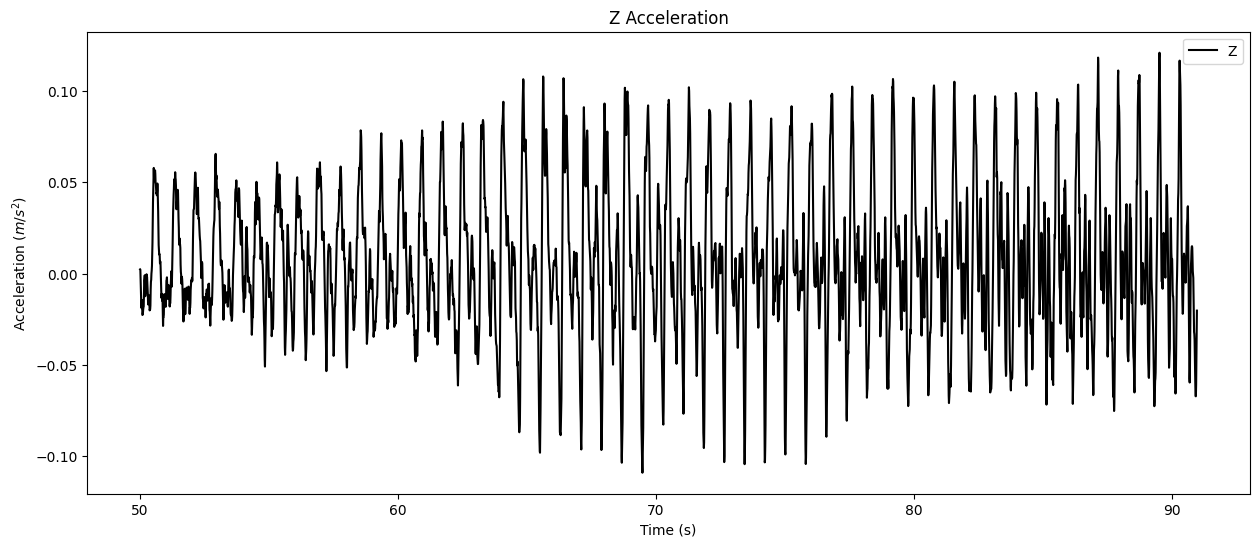

In [16]:
start_time = 50
n = 12
window_size = 0.01 * 2**n
print(f'n {2**n}')
print(f'window size {window_size}')
df = filter_time_window(df, label, start_time, window_size)
plot.acceleration(df, label, color='k')

## FFT analysis

In [17]:
label_corrected = f'{label} corrected'
df = analysis.baseline_correction(df, label, label_corrected)

In [18]:
df

,Time,Z Acceleration,Z corrected Acceleration
4999,50.00,0.002324,-0.005578
5000,50.01,0.002158,-0.005744
5001,50.02,-0.003840,-0.011742
5002,50.03,-0.010726,-0.018628
5003,50.04,-0.013874,-0.021775
...,...,...,...
9091,90.92,-0.067229,-0.074193
9092,90.93,-0.060694,-0.067658
9093,90.94,-0.046087,-0.053051
9094,90.95,-0.030665,-0.037629


In [19]:
df_fft = analysis.calculate_fft(df, label_corrected)

In [20]:
df_fft

,Frequency,Z corrected Magnitude
0,0.000000,1.577923e-15
1,0.024408,1.156870e+00
2,0.048816,1.011112e+00
3,0.073224,1.029693e+00
4,0.097632,1.082160e+00
...,...,...
2043,49.865755,8.225090e-03
2044,49.890164,8.619443e-03
2045,49.914572,8.063372e-03
2046,49.938980,8.520326e-03


## Denoising

In [21]:
label_filtered = f'{label} filtered'
threshold_percentage = 20
analysis.fft_filter(df=df, threshold_percentage=threshold_percentage, label=label_corrected, label_filtered=label_filtered)

,Time,Z Acceleration,Z corrected Acceleration,Z filtered Acceleration
4999,50.00,0.002324,-0.005578,-0.039732
5000,50.01,0.002158,-0.005744,-0.034511
5001,50.02,-0.003840,-0.011742,-0.027997
5002,50.03,-0.010726,-0.018628,-0.020759
5003,50.04,-0.013874,-0.021775,-0.013306
...,...,...,...,...
9091,90.92,-0.067229,-0.074193,-0.035280
9092,90.93,-0.060694,-0.067658,-0.040118
9093,90.94,-0.046087,-0.053051,-0.043300
9094,90.95,-0.030665,-0.037629,-0.044367


In [ ]:
label_filtered = f'{label} filtered'
threshold_percentage = 20
analysis.fft_filter(df=df_ssicov, threshold_percentage=threshold_percentage, label=label_corrected, label_filtered=label_filtered)

In [22]:
magnitude_type = 'calculated'
magnitude_factor = 1000
df_fft = analysis.calculate_fft(df, label_filtered, magnitude_type, magnitude_factor)

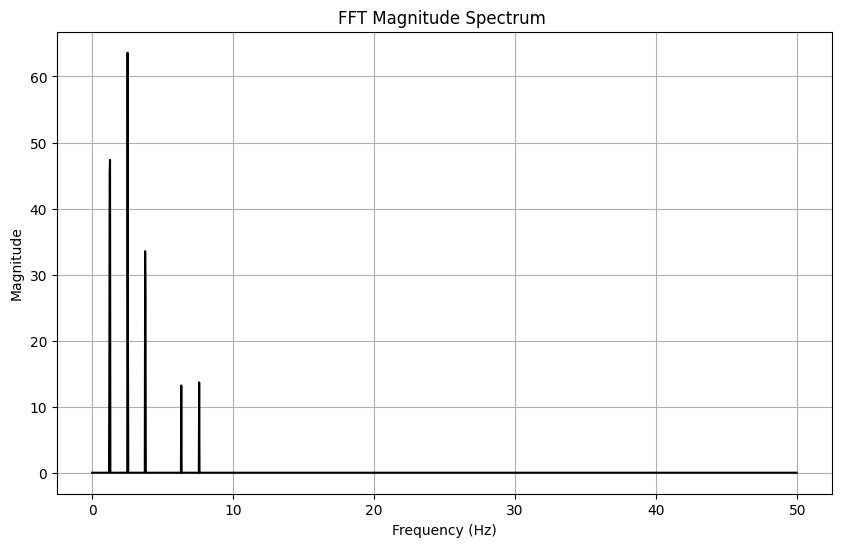

In [23]:
plot.fft_results(df_fft, label_filtered, 'k')

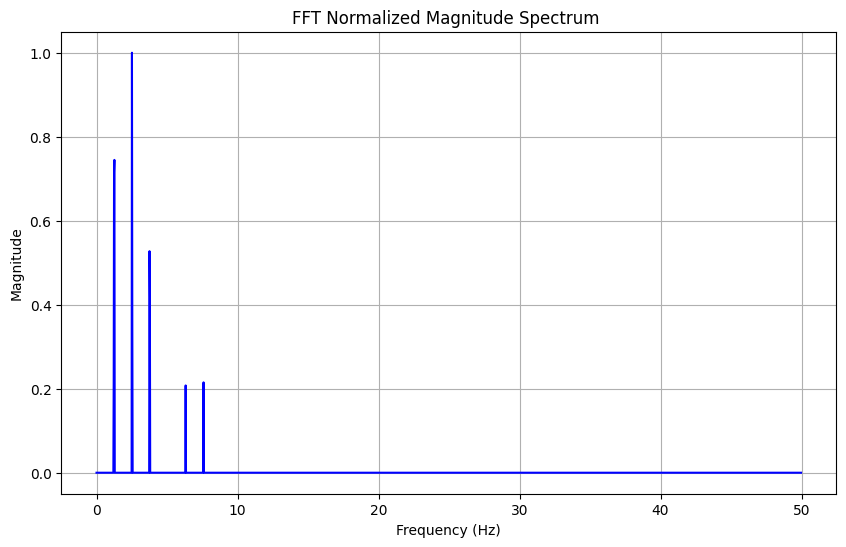

In [24]:
plot.normalized_fft_results(df_fft, label_filtered,'b')

In [25]:
wavelet ='morl'
min_scale = 1
max_scale = 32

In [26]:
spectrum, frequencies = analysis.cwt(df, label, wavelet, min_scale, max_scale)

In [27]:
gif_name = "wavelet_spectrum.gif"
file_location_gif = utils.get_results_files_location(gif_name)

In [28]:
analysis.wavelet_spectrum(df, label, wavelet, min_scale, max_scale, save_gif=True, file_location=file_location_gif, magnitude_type=magnitude_type, magnitude_factor=magnitude_factor)

interactive(children=(IntSlider(value=30, description='Elevation', max=90, step=5), IntSlider(value=0, descrip…

GIF saved as 'wavelet_spectrum.gif'


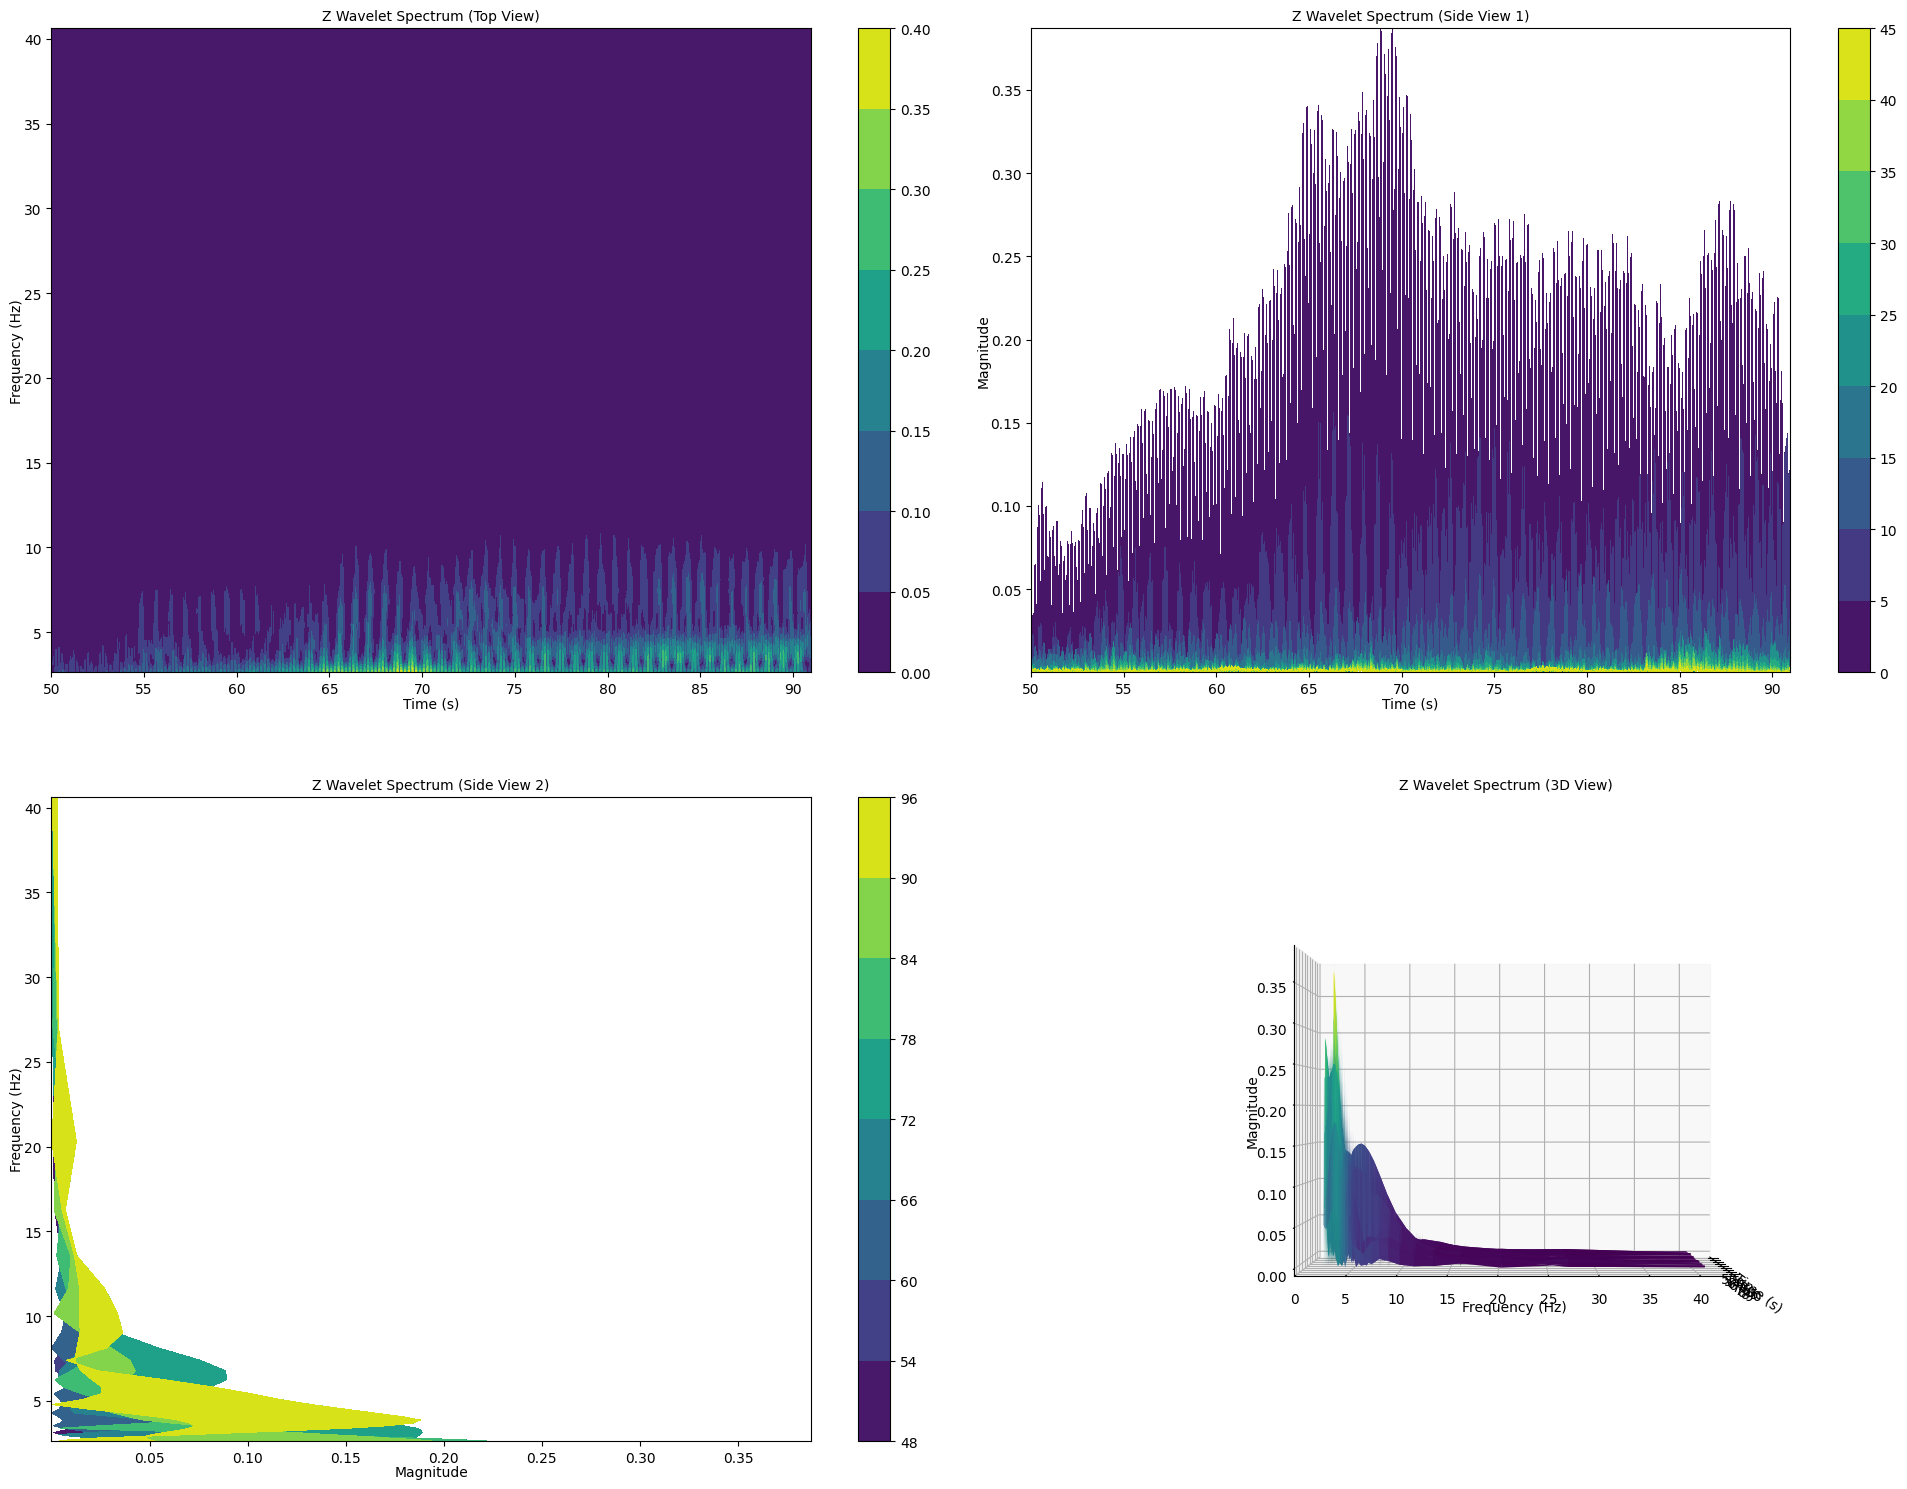

In [29]:
plot.wavelet_spectrum_views(df, spectrum, frequencies, label)

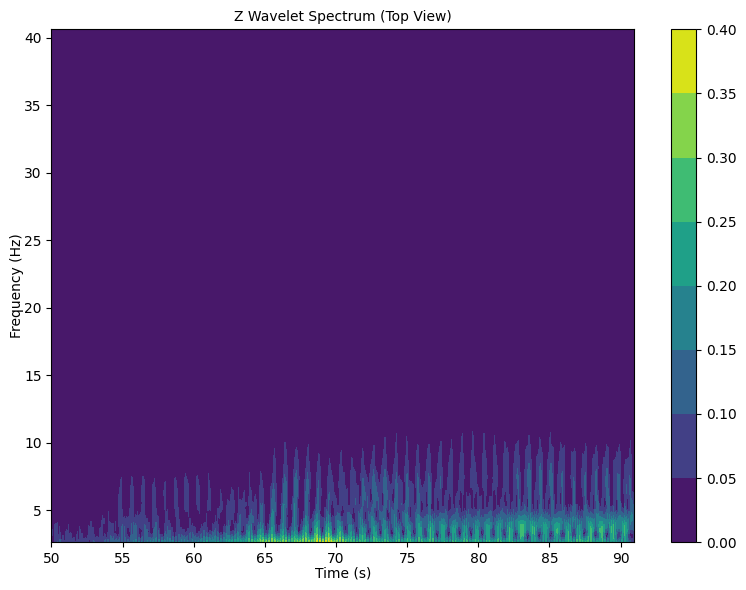

In [30]:
plot.wavelet_spectrum_time_frequency(df, spectrum, frequencies, label)

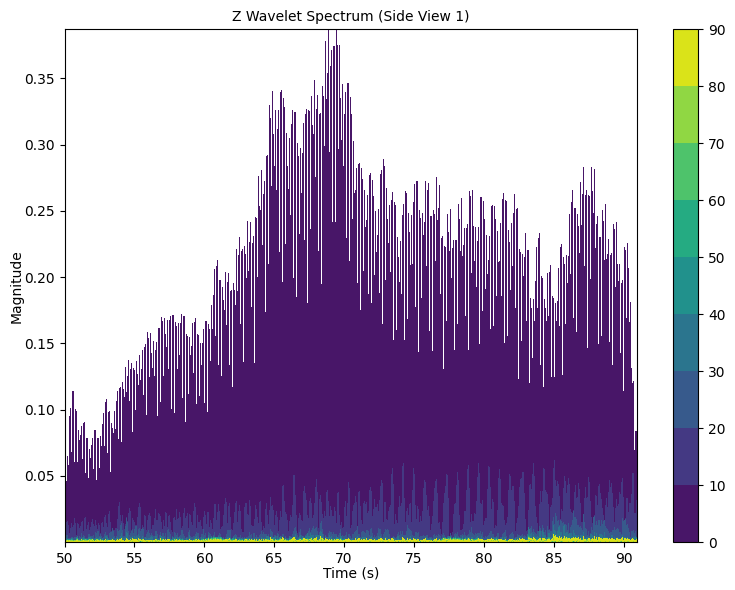

In [31]:
plot.wavelet_spectrum_time_magnitude(df, spectrum, frequencies, label)

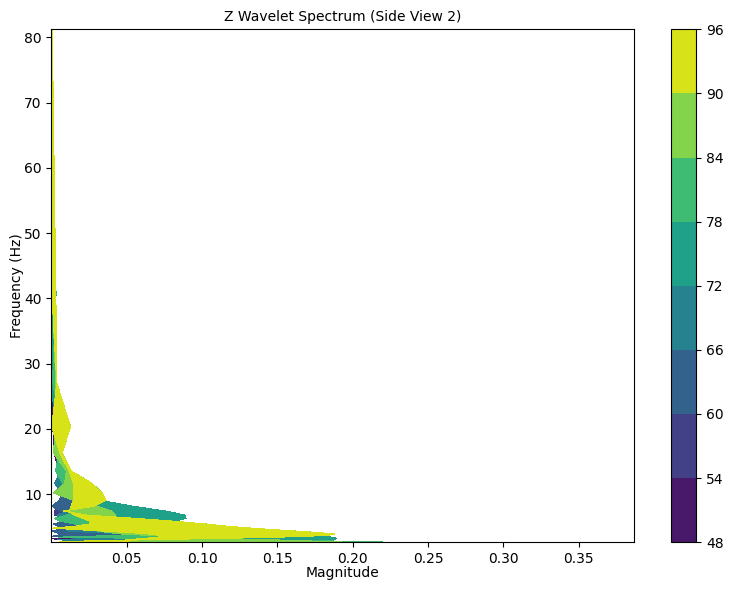

In [32]:
plot.wavelet_spectrum_frequency_magnitude(
    df,
    spectrum,
    frequencies,
    label
)

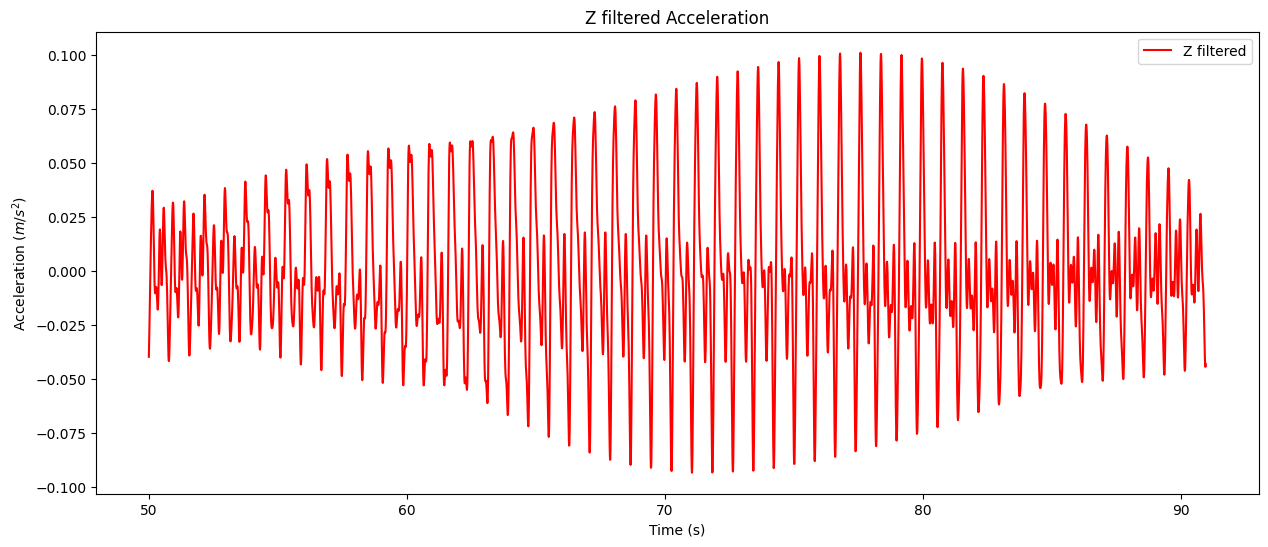

In [33]:
plot.acceleration(df, label_filtered)

In [34]:
df_fft_filtered = analysis.calculate_fft(df, label_filtered)

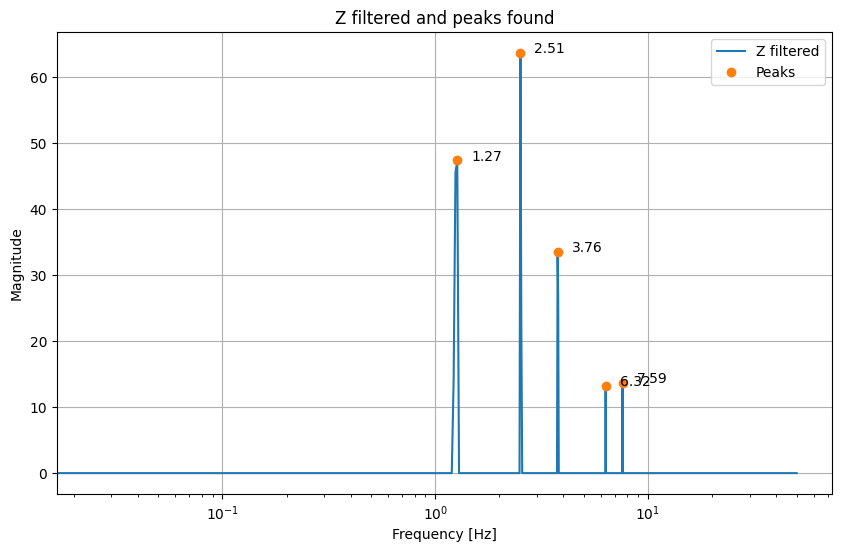

In [35]:
#plot.peaks(df_fft, label_filtered, log_scale=True)
plot.peaks(df_fft, label_filtered, log_scale=True)

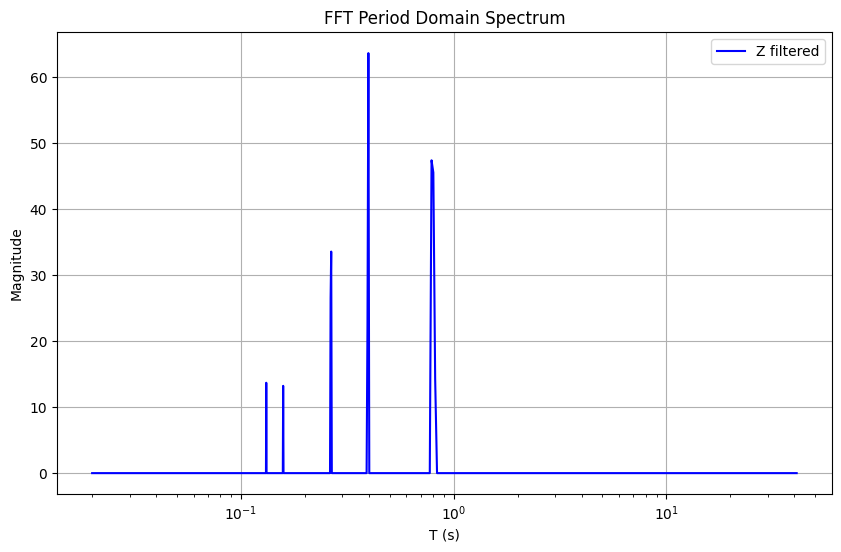

In [36]:
plot.fft_results_period_domain(df_fft, label_filtered, color='blue', log_scale=True)

In [ ]:
frequencies, power_spectrum, fn0, zeta0, number_poles = analysis.ssi_cov(df, label_filtered, Ts=20, Nmin=2, Nmax=32, threshold=1000)

In [ ]:
frequencies

array([2.44081035e-04, 4.88162070e-04, 7.32243105e-04, ...,
       4.99389797e-01, 4.99633878e-01, 4.99877959e-01])

In [ ]:
def plot_ssi_cov(
    frequencies: np.ndarray,
    power_spectrum: np.ndarray,
    label: str,
    fn0: np.ndarray = None,
    zeta0: np.ndarray = None,
    threshold: float = 0.01,
    color: str = "k",
):
    """
    Plots the SSCOV results and optionally the stability diagram.

    Args:
        frequencies: Frequencies corresponding to the power spectrum.
        power_spectrum: Power spectrum values.
        label: Data label (e.g., 'X').
        fn0: Natural Frequencies
        zeta0: Damping Ratio
        threshold: Threshold

    Returns:
        None (displays the plot).
    """
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.plot(frequencies, power_spectrum, color=color)
    ax1.set_xlabel("Frequency (Hz)")
    ax1.set_ylabel("Power")
    ax1.tick_params("y")
    ax1.grid(True)
    ax1.legend(loc="upper left", title=str(label))

    # Plot stability diagram on a second y-axis
    if fn0 is not None and zeta0 is not None:
        try:
            # Create the stability diagram based on threshold
            number_of_poles = np.zeros_like(frequencies)
            for i, freq in enumerate(frequencies):
                if freq > 0:
                    number_of_poles[i] = np.sum((fn0 >= freq - threshold) & (fn0 <= freq + threshold))

            ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
            ax2.plot(
                frequencies,
                number_of_poles,
                marker="o",
                linestyle="",
                color="tab:orange",
                label="Number of Poles",
            )
            ax2.set_ylabel(
                "Number of Poles", color="tab:orange"
            )  # we already handled the x-label with ax1
            ax2.tick_params(axis="y", labelcolor="tab:orange")
            #combine legends from both axes
            lines, labels = ax1.get_legend_handles_labels()
            lines2, labels2 = ax2.get_legend_handles_labels()
            ax1.legend(lines + lines2, labels + labels2, loc='upper right')

            # Check that both axes are covered
            fig.tight_layout()
            plt.title(f"Power Spectrum and Stability Diagram ({label})")
        except ValueError as ve:
            print(f"ValueError plotting stability data: {ve}. Skipping stability plot.")
        except Exception as e:
            print(f"Error plotting stability data: {e}. Skipping stability plot.")
    else:
        plt.title(f"Power Spectrum ({label})")

    plt.show()

In [ ]:
len(frequencies)

2048

In [ ]:
len(power_spectrum)

2048

In [ ]:
len(fn0)

20

In [ ]:
len(zeta0)

20

In [ ]:
len(number_poles)

2048

C:\Users\ingah\AppData\Local\Temp\ipykernel_14304\1310405658.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(loc="upper left", title=str(label))


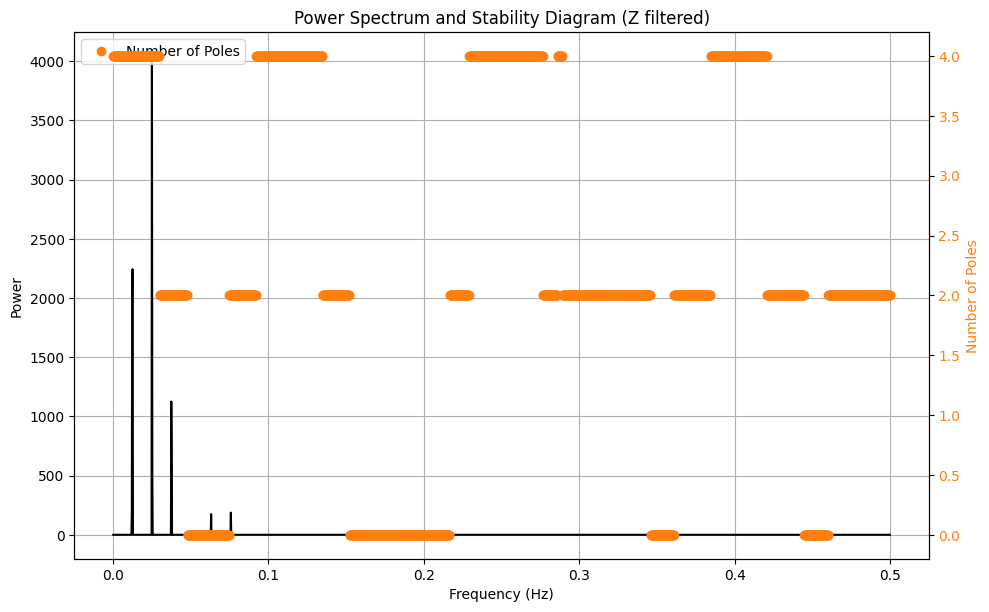

In [ ]:
plot_ssi_cov(frequencies, power_spectrum, label_filtered, fn0, zeta0, threshold=0.03)

In [46]:
def construct_and_svd_block_toeplitz(impulse_response_function: NDArray) -> Tuple[NDArray, NDArray, NDArray, NDArray]:
    """
    Constructs a block Toeplitz matrix from the given impulse response function and performs SVD.

    Args:
        impulse_response_function: Impulse Response Function as a NumPy array.

    Returns:
        A tuple containing:
            U: Left singular vectors from SVD.
            S: Singular values from SVD.
            V: Right singular vectors from SVD.
            block_toeplitz_matrix: The constructed block Toeplitz matrix.

    Assumptions:
        - impulse_response_function has shape (:, :, n) where n is odd.
    """
    number_channels = impulse_response_function.shape[0]
    irf_length = impulse_response_function.shape[2]
    block_size = number_channels
    num_blocks = irf_length - 1
    
    # Initialize lists to store blocks
    blocks = []
    # Algo nuevo: Barra de progreso para la construcción de la matriz de Toeplitz
    with tqdm(total=num_blocks * num_blocks, desc="Building Toeplitz Matrix", unit="block") as pbar:
        for i in range(num_blocks):
            row_blocks = []
            for j in range(num_blocks):
                if i >= j:
                    row_blocks.append(impulse_response_function[:, :, i - j])
                else:
                    row_blocks.append(np.zeros_like(impulse_response_function[:, :, 0]))  # Corrected line
                pbar.update(1)
            blocks.append(row_blocks)
    # Concatenate blocks to form the block Toeplitz matrix
    block_toeplitz_matrix = np.block(blocks)
    del blocks  # Free up memory
    gc.collect()
    
    # Perform Singular Value Decomposition
    U, S, V = svd(block_toeplitz_matrix)
    del block_toeplitz_matrix
    gc.collect()
    
    return U, S, V, block_toeplitz_matrix

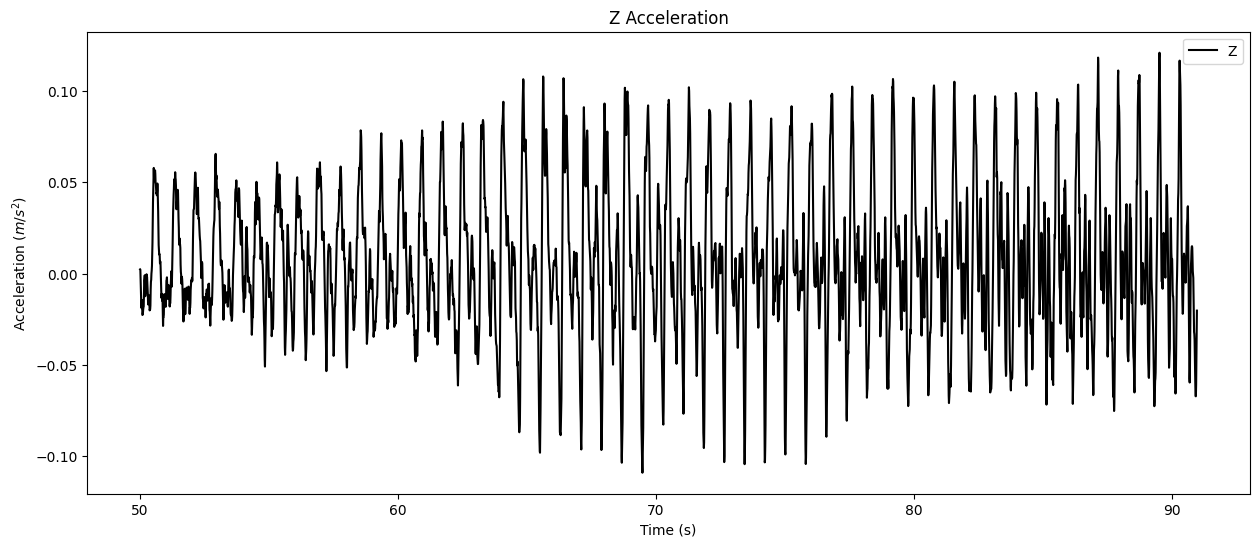

In [47]:
df_ssicov = filter_time_window(df_ssicov, label, start_time, window_size)
plot.acceleration(df_ssicov, label, color='k')

In [48]:
df = df_ssicov

In [49]:
df

,Time,X Acceleration,Y Acceleration,Z Acceleration
4999,50.00,-0.000645,0.004047,0.002324
5000,50.01,0.000476,0.010503,0.002158
5001,50.02,-0.000388,0.008642,-0.003840
5002,50.03,-0.001417,0.010029,-0.010726
5003,50.04,-0.001141,0.011396,-0.013874
...,...,...,...,...
9091,90.92,-0.002005,0.026843,-0.067229
9092,90.93,-0.001435,0.020150,-0.060694
9093,90.94,-0.003641,0.017269,-0.046087
9094,90.95,-0.002281,0.014169,-0.030665


In [50]:
ssicov = analysis.SSICOV(df_ssicov, labels, min_model_order=2, max_model_order=32)

In [ ]:
number_modes = 3
singular_values = 32
fs = 200

In [ ]:
stable_frequencies, stable_damping_ratios, stable_mode_shapes, stable_MAC_values, stability_statuses, natural_frequencies = ssicov.execute_ssicov_analysis()

Building Toeplitz Matrix: 100%|██████████| 16760836/16760836 [00:27<00:00, 620613.05block/s] 


In [ ]:
stable_damping_ratios

array([], dtype=float64)

In [ ]:
df

,Time,X Acceleration,Y Acceleration,Z Acceleration
4999,50.00,-0.000645,0.004047,0.002324
5000,50.01,0.000476,0.010503,0.002158
5001,50.02,-0.000388,0.008642,-0.003840
5002,50.03,-0.001417,0.010029,-0.010726
5003,50.04,-0.001141,0.011396,-0.013874
...,...,...,...,...
6019,60.20,0.002038,-0.015614,0.033612
6020,60.21,0.000936,0.000436,0.024874
6021,60.22,0.001506,-0.000732,0.013988
6022,60.23,0.001469,0.005761,0.014414


Acceleration data shape: (1025, 3)
aquí


c:\Users\ingah\miniforge3\envs\epy\Lib\site-packages\scipy\signal\_spectral_py.py:600: UserWarning: nperseg = 2048 is greater than input length  = 1025, using nperseg = 1025
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


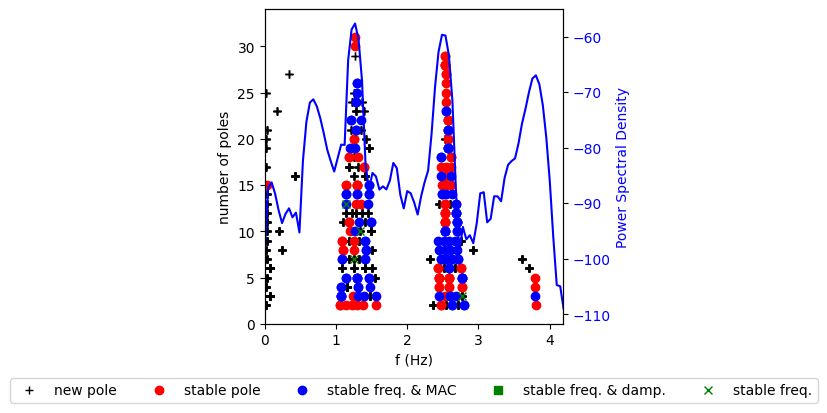

In [ ]:
plot.stability_diagram(
    df=df_ssicov,
    acceleration_labels=labels,
    natural_frequencies=natural_frequencies,
    stability_status=stability_statuses,
    min_model_order=2,
    max_model_order=32,
    lower_frequency_bound=0,
    upper_frequency_bound=30
)